# Problem Statement: Analysis of Housing Market Trends and Price Predictors
## Background
The real estate market is a significant component of the economy, reflecting a complex interplay of factors including location, property attributes, and economic trends. Understanding the dynamics of housing prices is crucial for buyers, sellers, real estate agents, and policymakers.

## Objective
This project aims to analyze and understand the housing market trends in the USA, focusing on how various factors such as the number of bedrooms, bathrooms, lot size, house size, and location attributes (city, state, and zip code) correlate with housing prices.

## Data
The dataset contains information on properties listed for sale, including their IDs, number of bedrooms and bathrooms, acre lot, house size, sale status, price, and location details (city, zip code, state). A snippet of the data is as follows:



Parsed the raw data using Python.

Loaded the parsed data into a normalized database table.

Data Analysis Component: Utilize SQL join statements to retrieve data into Pandas for analysis


Acknowledgements
Data was collected from -

https://www.realtor.com/ - A real estate listing website operated by the News Corp subsidiary Move, Inc. and based in Santa Clara, California. It is the second most visited real estate listing website in the United States as of 2021, with over 100 million monthly active users.




## Key Questions

## Price Prediction: 
#### Can we develop a model to predict housing prices based on property attributes and location?
Correlation Analysis: How are property attributes like the number of bedrooms and bathrooms correlated with housing prices? Are there noticeable trends or patterns?
Geographical Trends: What is the overall landscape of housing prices in the USA concerning locations? How do housing prices vary across different states and cities?
Market Insights: Are there any hidden patterns in the market, such as the influence of specific property features on price that are not immediately apparent?

## Expected Outcome
The project aims to provide a comprehensive analysis of the housing market, uncovering key trends and patterns that can guide potential buyers, sellers, and other stakeholders in making informed decisions. Additionally, the development of a predictive model will aid in estimating property values based on their characteristics and location, offering a valuable tool for real estate valuation.

In [3]:
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):

    if drop_table_name: 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)

    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


file_path = 'realtor-data.csv'


status=[]
bed=[]
bath=[]
acre_lot=[]
city=[]
state=[]
zip_code=[]
house_size=[]
price=[]

with open(file_path, 'r') as file:
    lines = file.readlines()
    header=lines[0]
    print(header.strip().split(","))
    for i in range(len(lines)-1):
      values = lines[i+1].strip().split(',')
      if("" not in values[0:8]):
        status.append(values[0])
        bed.append(int(values[1]))
        bath.append(int(values[2]))
        acre_lot.append(float(values[3]))
        city.append(values[4])
        state.append(values[5])
        zip_code.append(values[6])
        house_size.append(int(values[7]))
        price.append(int(values[9]))

state_set = sorted((list(set(state))))
conn_norm = create_connection('project.db',True)
SqlRegion = '''CREATE TABLE [STATE] ( State_Id INTEGER PRIMARY KEY, State_Name TEXT NOT NULL)'''
create_table(conn_norm,SqlRegion)

count = 0
for i in state_set:
    count = count+1
    sql_statement = f"INSERT INTO STATE (State_Id,State_Name) VALUES ({count},'{i}')"
    df = execute_sql_statement(sql_statement, conn_norm)
conn_norm.commit()


city_set = sorted((list(set(city))))
SqlRegion = '''CREATE TABLE [CITY] ( City_Id INTEGER PRIMARY KEY, City_Name TEXT NOT NULL)'''
create_table(conn_norm,SqlRegion)

count = 0
for i in city_set:
    count = count+1
    sql_statement = f"INSERT INTO CITY (City_Id,City_Name) VALUES ({count},'{i}')"
    df = execute_sql_statement(sql_statement, conn_norm)
conn_norm.commit()

zip_code_set = sorted((list(set(zip_code))))
SqlRegion = '''CREATE TABLE [ZIP] ( Zip_Id INTEGER PRIMARY KEY, Zip_Code TEXT NOT NULL)'''
create_table(conn_norm,SqlRegion)

count = 0
for i in zip_code_set:
    count = count+1
    sql_statement = f"INSERT INTO ZIP (Zip_Id,Zip_Code) VALUES ({count},'{i}')"
    df = execute_sql_statement(sql_statement, conn_norm)
conn_norm.commit()

SqlRegion = '''CREATE TABLE [PROPERTY_ADDRESS] (Property_Id INTEGER PRIMARY KEY, Zip_Id INTEGER NOT NULL,City_Id INTEGER ,State_Id INTEGER,  FOREIGN KEY (City_Id) REFERENCES CITY(City_Id) ,FOREIGN KEY (State_Id) REFERENCES STATE(State_Id) ,FOREIGN KEY (Zip_Id) REFERENCES ZIP(Zip_Id))'''
create_table(conn_norm,SqlRegion)
zip_prop = list(zip(zip_code,city,state))

sql_stat = f"SELECT * FROM STATE"
df = execute_sql_statement(sql_stat,conn_norm)
S_ID = list(map(lambda deg:deg[0],df))
State_Name  = list(map(lambda deg:deg[1],df))
State_dict = dict(zip(State_Name,S_ID))

sql_stat = f"SELECT * FROM CITY"
df = execute_sql_statement(sql_stat,conn_norm)
City_ID = list(map(lambda deg:deg[0],df))
City_Name  = list(map(lambda deg:deg[1],df))
City_dict = dict(zip(City_Name,City_ID))

sql_stat = f"SELECT * FROM ZIP"
df = execute_sql_statement(sql_stat,conn_norm)
Zip_ID = list(map(lambda deg:deg[0],df))
Zip_Name  = list(map(lambda deg:deg[1],df))
Zip_dict = dict(zip(Zip_Name,Zip_ID))


count = 0
data = []
for i in zip_prop:
  count=count+1
  data.append((count,Zip_dict[i[0]],City_dict[i[1]],State_dict[i[2]]))

sql = f"INSERT INTO PROPERTY_ADDRESS (Property_Id,Zip_Id,City_Id,State_Id) VALUES (?,?,?,?)"
conn_norm.executemany(sql,data)
conn_norm.commit()

SqlRegion = '''CREATE TABLE [PROPERTY_DETAILS] (Property_Id INTEGER NOT NULL, No_Of_BedRooms INTEGER NOT NULL,No_Of_BathRooms INTEGER NOT NULL,Acre_Lot REAL NOT NULL,House_Size INTEGER,  FOREIGN KEY (Property_Id) REFERENCES PROPERTY_ADDRESS(Property_Id))'''
create_table(conn_norm,SqlRegion)
zip_prop_Add = list(zip(bed,bath,acre_lot,house_size))

count = 0
data = []
for i in zip_prop_Add:
  count=count+1
  data.append((count,i[0],i[1],i[2],i[3]))

sql = f"INSERT INTO PROPERTY_DETAILS (Property_Id,No_Of_BedRooms,No_Of_BathRooms,Acre_Lot,House_Size) VALUES (?,?,?,?,?)"
conn_norm.executemany(sql,data)
conn_norm.commit()

Status_set = sorted((list(set(status))))
SqlRegion = '''CREATE TABLE [PROPERTY_STATUS] ( Property_Status_Id INTEGER PRIMARY KEY, Status TEXT NOT NULL)'''
create_table(conn_norm,SqlRegion)

count = 0
for i in Status_set:
    count = count+1
    sql_statement = f"INSERT INTO PROPERTY_STATUS (Property_Status_Id,Status) VALUES ({count},'{i}')"
    df = execute_sql_statement(sql_statement, conn_norm)
conn_norm.commit()

sql_stat = f"SELECT * FROM PROPERTY_STATUS"
df = execute_sql_statement(sql_stat,conn_norm)
Stat_ID = list(map(lambda deg:deg[0],df))
Stat_Name  = list(map(lambda deg:deg[1],df))
Stat_dict = dict(zip(Stat_Name,Stat_ID))

SqlRegion = '''CREATE TABLE [PROPERTY_PRICE] (Property_Id INTEGER NOT NULL, Property_Status_Id INTEGER NOT NULL,Price INTEGER NOT NULL, FOREIGN KEY (Property_Status_Id) REFERENCES PROPERTY_STATUS (Property_Status_Id) ,FOREIGN KEY (Property_Id) REFERENCES PROPERTY_ADDRESS(Property_Id))'''
create_table(conn_norm,SqlRegion)
zip_prop_Price = list(zip(status,price))
count = 0
data = []
for i in zip_prop_Price:
  count=count+1
  data.append((count,Stat_dict[i[0]],i[1]))

sql = f"INSERT INTO PROPERTY_PRICE (Property_Id,Property_Status_Id,Price) VALUES (?,?,?)"

conn_norm.executemany(sql,data)
conn_norm.commit()

['status', 'bed', 'bath', 'acre_lot', 'city', 'state', 'zip_code', 'house_size', 'prev_sold_date', 'price']


In [4]:
pip install pandas sqlite3

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sqlite3
import matplotlib.pyplot as plt

conn = sqlite3.connect('project.db')

In [6]:
import pandas as pd
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)

In [7]:
# This output shows the structure of each table in the database, including column names, types, and other properties.
#This is a special SQLite command used to get information about the columns of a table.
for table in tables['name']:
    query = f"PRAGMA table_info({table});"
    print(f"Table: {table}")
    print(pd.read_sql_query(query, conn))

Table: STATE
   cid        name     type  notnull dflt_value  pk
0    0    State_Id  INTEGER        0       None   1
1    1  State_Name     TEXT        1       None   0
Table: CITY
   cid       name     type  notnull dflt_value  pk
0    0    City_Id  INTEGER        0       None   1
1    1  City_Name     TEXT        1       None   0
Table: ZIP
   cid      name     type  notnull dflt_value  pk
0    0    Zip_Id  INTEGER        0       None   1
1    1  Zip_Code     TEXT        1       None   0
Table: PROPERTY_ADDRESS
   cid         name     type  notnull dflt_value  pk
0    0  Property_Id  INTEGER        0       None   1
1    1       Zip_Id  INTEGER        1       None   0
2    2      City_Id  INTEGER        0       None   0
3    3     State_Id  INTEGER        0       None   0
Table: PROPERTY_DETAILS
   cid             name     type  notnull dflt_value  pk
0    0      Property_Id  INTEGER        1       None   0
1    1   No_Of_BedRooms  INTEGER        1       None   0
2    2  No_Of_BathRoo

# DATA ANALYSIS

# Overview of Property Prices

In [8]:

conn = sqlite3.connect('project.db')

query_overview = """
SELECT c.City_Name, AVG(p.Price) AS Average_Price
FROM CITY AS c
JOIN PROPERTY_ADDRESS AS pa ON c.City_Id = pa.City_Id
JOIN PROPERTY_PRICE AS p ON pa.Property_Id = p.Property_Id
GROUP BY c.City_Name
ORDER BY Average_Price DESC;
"""

overview_prices = pd.read_sql_query(query_overview, conn)

print(overview_prices.head())


          City_Name  Average_Price
0  Upper Brookville   1.172150e+07
1  Rochdale Village   9.800000e+06
2           Tisbury   9.260000e+06
3          Waccabuc   9.157692e+06
4          Brooklin   9.000000e+06


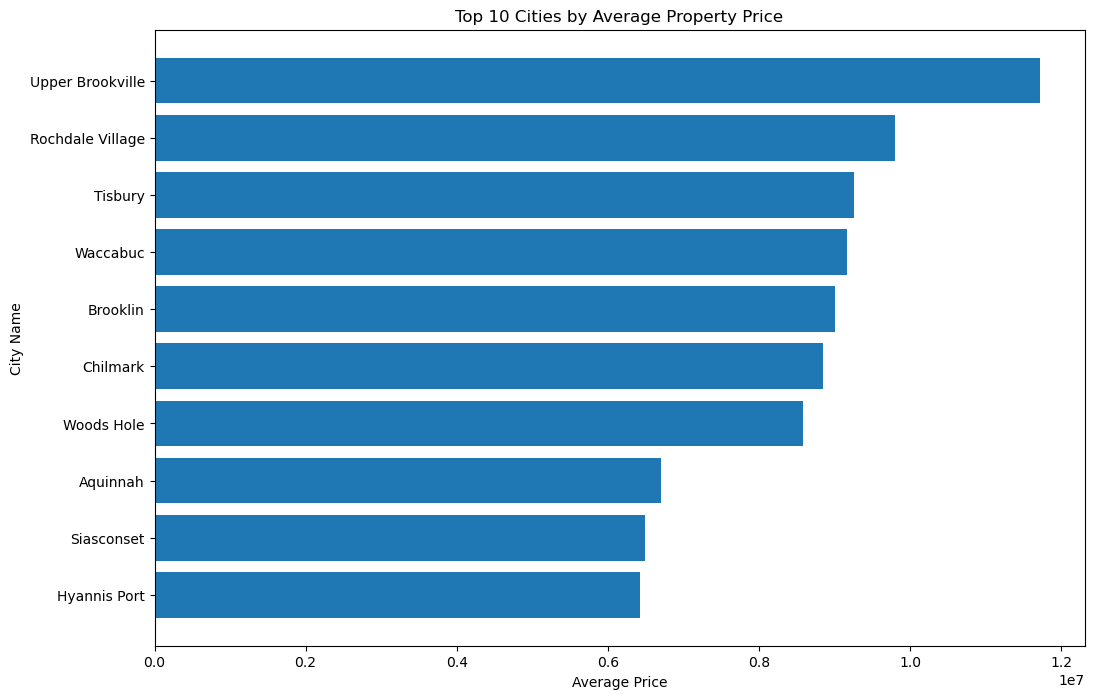

In [9]:
plt.figure(figsize=(12, 8))
plt.barh(overview_prices['City_Name'].head(10), overview_prices['Average_Price'].head(10))
plt.xlabel('Average Price')
plt.ylabel('City Name')
plt.title('Top 10 Cities by Average Property Price')
plt.gca().invert_yaxis()
plt.show()


### Based on the bar chart showing the top 10 cities by average property price:

Variation in Housing Prices: There's a noticeable variation in housing prices across different cities, with Upper Brookbville displaying the highest average prices among the listed locations.

Premium Locations: The top cities, especially Upper Brookbville, may represent more affluent areas or markets with luxury properties.

Market Trends: The data indicates market trends that could be crucial for real estate investment decisions, highlighting potential areas for high-value investments.

# Price Distribution by State

In [10]:
# Query to analyze the price distribution by state
query_distribution = """
SELECT s.State_Name,
       AVG(p.Price) AS Average_Price,
       MIN(p.Price) AS Minimum_Price,
       MAX(p.Price) AS Maximum_Price,
       COUNT(*) AS Total_Properties
FROM STATE AS s
JOIN PROPERTY_ADDRESS AS pa ON s.State_Id = pa.State_Id
JOIN PROPERTY_PRICE AS p ON pa.Property_Id = p.Property_Id
GROUP BY s.State_Name
ORDER BY Average_Price DESC;
"""

price_distribution = pd.read_sql_query(query_distribution, conn)


print(price_distribution)


        State_Name  Average_Price  Minimum_Price  Maximum_Price  \
0   Virgin Islands   1.953334e+06         100000       16999000   
1         New York   1.285043e+06          20000      169000000   
2    Massachusetts   1.056068e+06          10000       30000000   
3      Connecticut   6.700760e+05          34900      100000000   
4    New Hampshire   6.423393e+05           9000       19500000   
5       New Jersey   5.771316e+05            500       24900000   
6          Vermont   5.721094e+05          27500        8000000   
7          Wyoming   5.350000e+05         535000         535000   
8            Maine   5.298203e+05          10000        9000000   
9     Rhode Island   5.267448e+05          85000       14000000   
10    Pennsylvania   3.934454e+05          15000       29900000   
11     Puerto Rico   3.911274e+05          19900       19500000   
12        Delaware   3.418941e+05          21497        3950000   
13   West Virginia   6.250000e+04          62500          6250

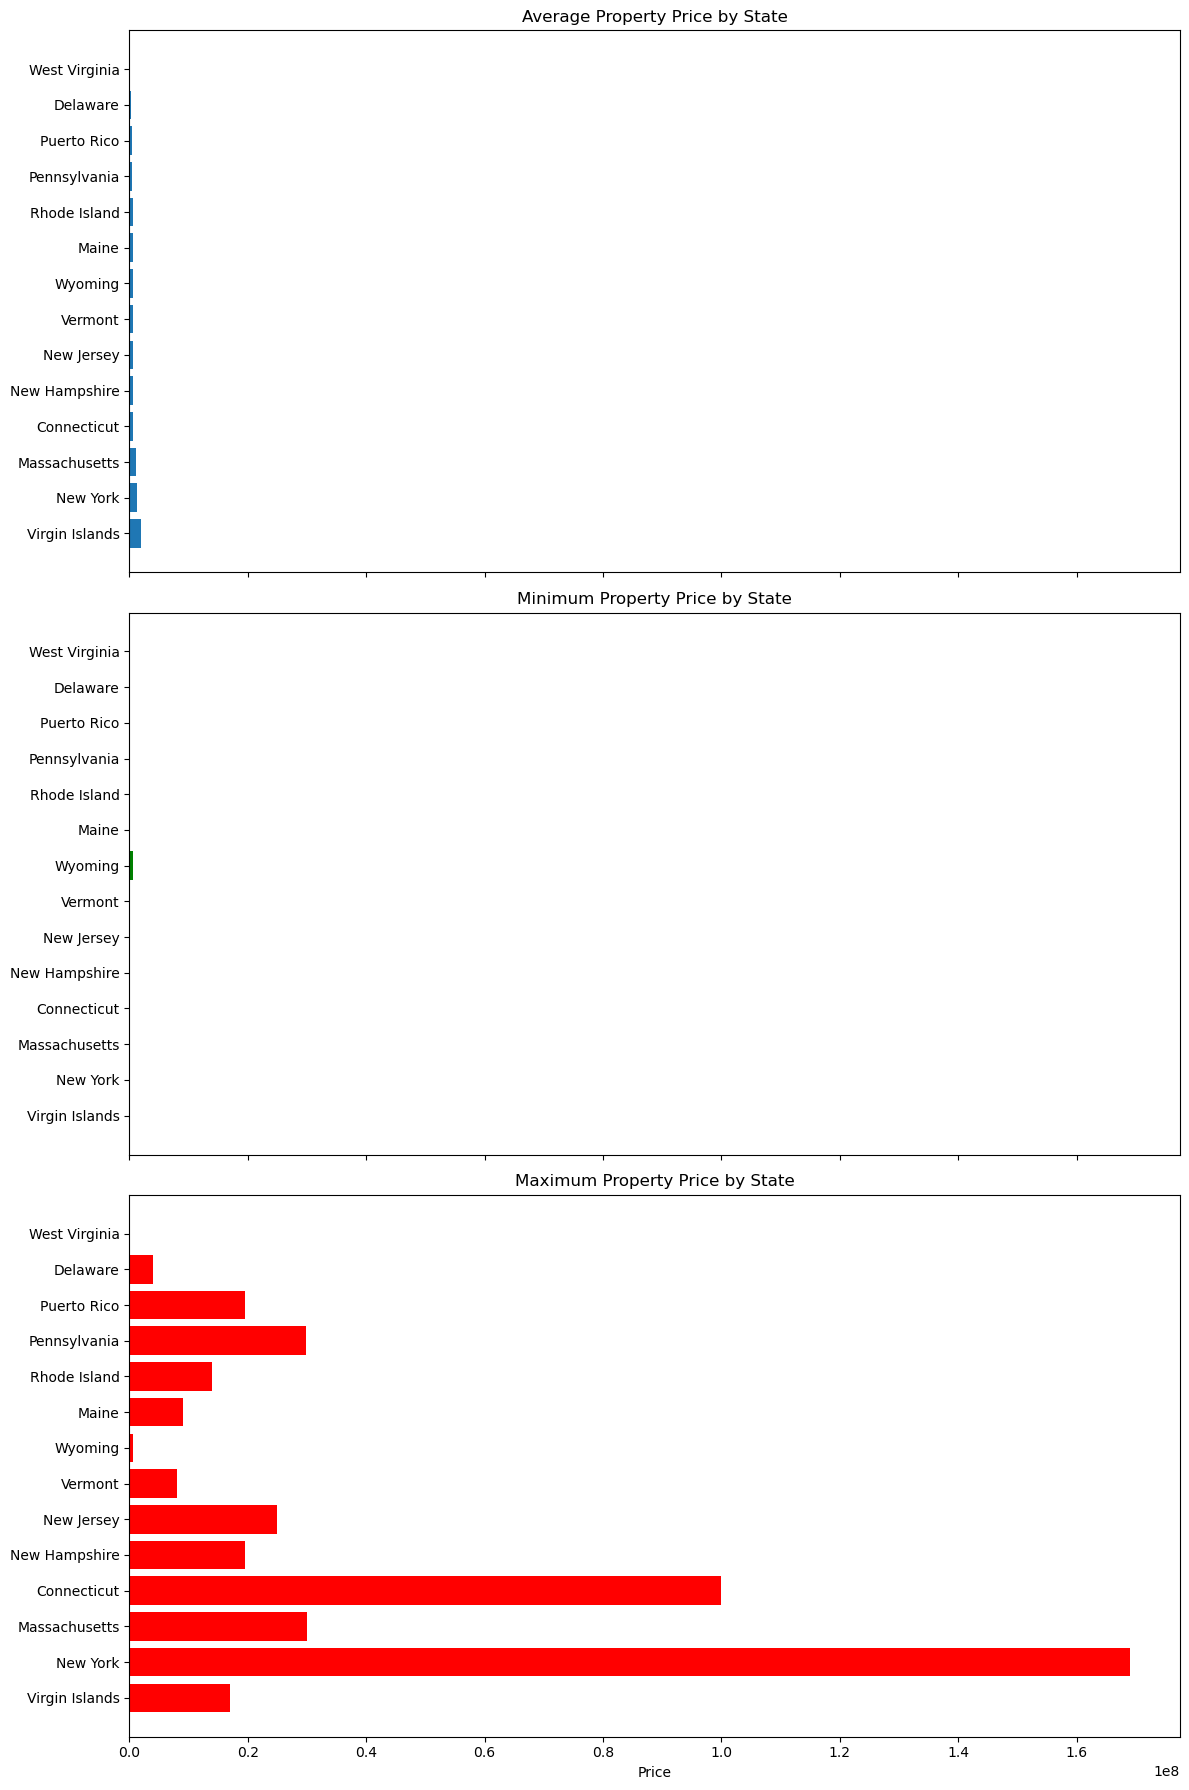

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Average Price by State
ax[0].barh(price_distribution['State_Name'], price_distribution['Average_Price'])
ax[0].set_title('Average Property Price by State')

# Minimum Price by State
ax[1].barh(price_distribution['State_Name'], price_distribution['Minimum_Price'], color='green')
ax[1].set_title('Minimum Property Price by State')

# Maximum Price by State
ax[2].barh(price_distribution['State_Name'], price_distribution['Maximum_Price'], color='red')
ax[2].set_title('Maximum Property Price by State')

plt.xlabel('Price')
plt.tight_layout()
plt.show()


### Average Property Price by State:
Chart shows significant differences in average property prices across states, with the Virgin Islands and New York being notably higher.

### Minimum Property Price by State:
Wyoming and Vermont have lower minimum property prices, suggesting more affordable housing markets.

### Maximum Property Price by State:
The maximum prices in the Virgin Islands and New York are exceptionally high, indicating these areas likely have luxury real estate markets.

# Property Characteristics and Prices

In [12]:
# how the number of bedrooms and bathrooms might influence property prices.
query_characteristics = """
SELECT d.No_Of_BedRooms, d.No_Of_BathRooms,
       AVG(p.Price) AS Average_Price,
       COUNT(*) AS Property_Count
FROM PROPERTY_DETAILS AS d
JOIN PROPERTY_PRICE AS p ON d.Property_Id = p.Property_Id
GROUP BY d.No_Of_BedRooms, d.No_Of_BathRooms
ORDER BY Average_Price DESC;
"""

property_characteristics = pd.read_sql_query(query_characteristics, conn)
print(property_characteristics.head())


   No_Of_BedRooms  No_Of_BathRooms  Average_Price  Property_Count
0              16               21   4.500000e+07               2
1              13               17   3.880000e+07               1
2               7               14   2.950000e+07              10
3              10               18   1.790000e+07               1
4               8               10   1.758008e+07             119


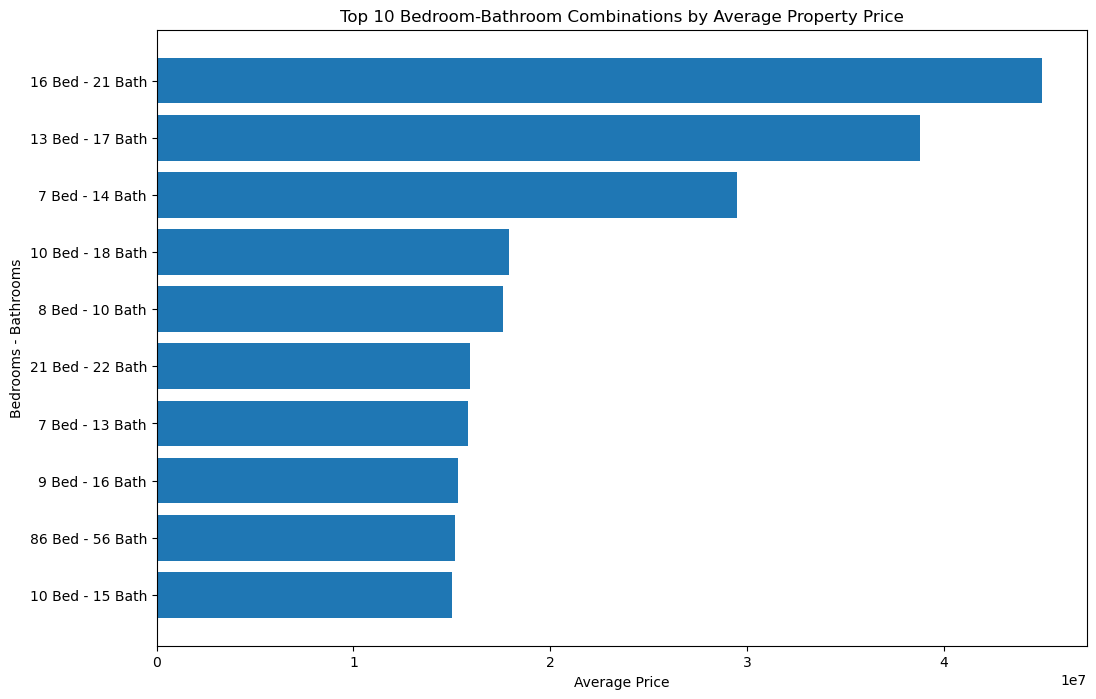

In [13]:
plt.figure(figsize=(12, 8))
property_characteristics['Bed_Bath'] = (
    property_characteristics['No_Of_BedRooms'].astype(str) + ' Bed - ' +
    property_characteristics['No_Of_BathRooms'].astype(str) + ' Bath'
)
property_characteristics_sorted = property_characteristics.sort_values(by='Average_Price', ascending=False)
plt.barh(property_characteristics_sorted['Bed_Bath'].head(10), property_characteristics_sorted['Average_Price'].head(10))
plt.xlabel('Average Price')
plt.ylabel('Bedrooms - Bathrooms')
plt.title('Top 10 Bedroom-Bathroom Combinations by Average Property Price')
plt.gca().invert_yaxis()
plt.show()


# High-Value Property Hotspots

In [14]:
# Query to find cities with the highest value properties
query_high_value = """
SELECT c.City_Name, MAX(p.Price) AS Highest_Price
FROM CITY AS c
JOIN PROPERTY_ADDRESS AS pa ON c.City_Id = pa.City_Id
JOIN PROPERTY_PRICE AS p ON pa.Property_Id = p.Property_Id
GROUP BY c.City_Name
ORDER BY Highest_Price DESC;
"""

high_value_cities = pd.read_sql_query(query_high_value, conn)
print(high_value_cities.head())


       City_Name  Highest_Price
0  New York City      169000000
1         Darien      100000000
2      Woodstock       60000000
3      Greenwich       40000000
4     Great Neck       40000000


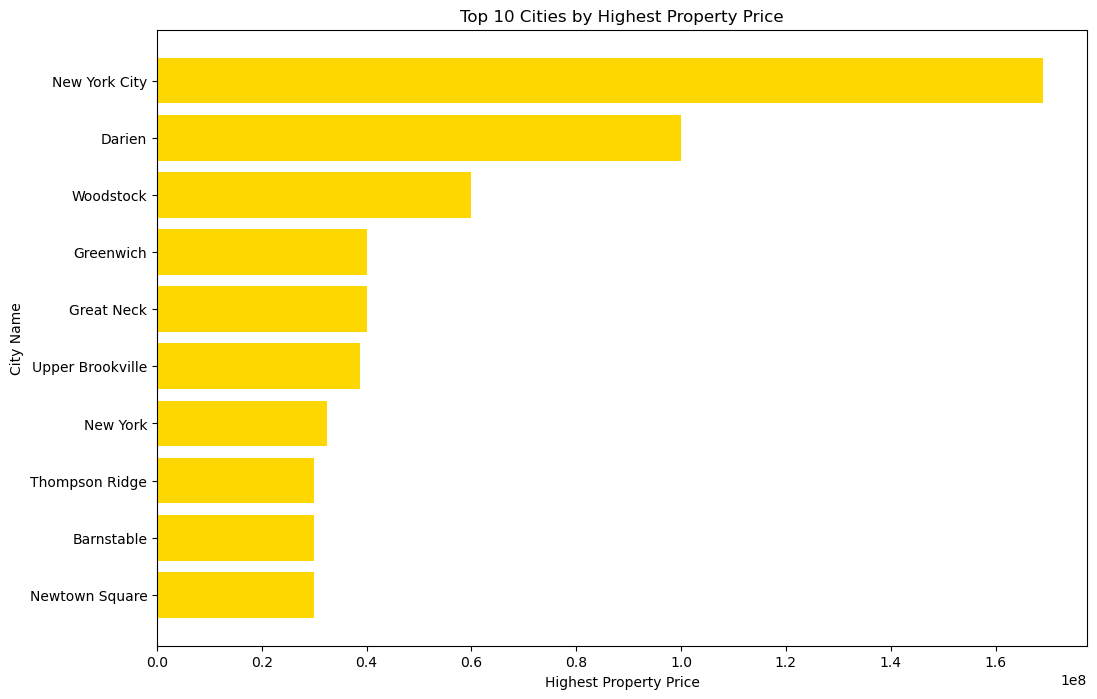

In [15]:
plt.figure(figsize=(12, 8))
plt.barh(high_value_cities['City_Name'].head(10), high_value_cities['Highest_Price'].head(10), color='gold')
plt.xlabel('Highest Property Price')
plt.ylabel('City Name')
plt.title('Top 10 Cities by Highest Property Price')
plt.gca().invert_yaxis()
plt.show()


## What is the Distribution of Property Sizes (House Size) in Each State?


In [16]:
query3 = """
SELECT s.State_Name, d.House_Size
FROM STATE AS s
JOIN PROPERTY_ADDRESS AS pa ON s.State_Id = pa.State_Id
JOIN PROPERTY_DETAILS AS d ON pa.Property_Id = d.Property_Id;
"""

property_size_distribution = pd.read_sql_query(query3, conn)

print(property_size_distribution)

         State_Name  House_Size
0       Puerto Rico         920
1       Puerto Rico        1527
2       Puerto Rico         748
3       Puerto Rico        1800
4       Puerto Rico        2520
...             ...         ...
471557     New York        2000
471558     New York        1596
471559     New York        1750
471560     New York        3100
471561     New York        2574

[471562 rows x 2 columns]


## Correlation between Property Size and Price in New York

In [17]:
# SQL query for correlation between property size and price in New York
query5 = """
SELECT d.House_Size, p.Price
FROM PROPERTY_DETAILS AS d
JOIN PROPERTY_PRICE AS p ON d.Property_Id = p.Property_Id
JOIN PROPERTY_ADDRESS AS pa ON d.Property_Id = pa.Property_Id
JOIN CITY AS c ON pa.City_Id = c.City_Id
WHERE c.City_Name = 'New York';
"""

size_price_correlation = pd.read_sql_query(query5, conn)

print(size_price_correlation)

     House_Size     Price
0         40720    389000
1          4030   4200000
2          6366   5500000
3         11371  32500000
4          1920    625000
..          ...       ...
426        1692    709999
427         790    899000
428       11371  32500000
429        5304   3950000
430        2600   2995000

[431 rows x 2 columns]


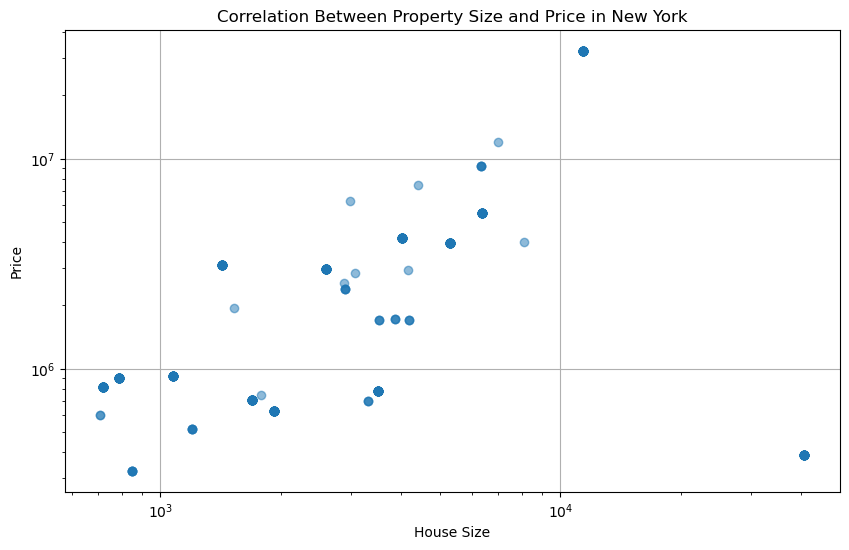

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(size_price_correlation['House_Size'], size_price_correlation['Price'], alpha=0.5)
plt.title('Correlation Between Property Size and Price in New York')
plt.xlabel('House Size')
plt.ylabel('Price')
plt.xscale('log') 
plt.yscale('log')
plt.grid(True)
plt.show()


In [19]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):

    if drop_table_name: # You can optionally pass drop_table_name to drop the table.
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)

    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

conn_norm = create_connection('project.db')

sql_query = '''
SELECT
    PA.Property_Id,
    PS.Status,
    PD.No_Of_BedRooms,
    PD.No_Of_BathRooms,
    PD.Acre_Lot,
    PD.House_Size,
    CITY.City_Id,
    ZIP.Zip_Id,
    PP.Price,
    CITY.City_Name,
    ZIP.Zip_Code,
    STATE.State_Name
FROM PROPERTY_ADDRESS PA
JOIN PROPERTY_DETAILS PD ON PA.Property_Id = PD.Property_Id
JOIN PROPERTY_STATUS PS ON PA.Property_Id = PP.Property_Id
JOIN PROPERTY_PRICE PP ON PA.Property_Id = PP.Property_Id
JOIN ZIP ON PA.Zip_Id = ZIP.Zip_Id
JOIN CITY ON PA.City_Id = CITY.City_Id
JOIN STATE ON PA.State_Id = STATE.State_Id
'''

df_result = pd.read_sql_query(sql_query, conn_norm)

In [20]:
df_result.head()

Property_Id    Status  No_Of_BedRooms  No_Of_BathRooms  Acre_Lot  \
0            1  for_sale               3                2      0.12   
1            2  for_sale               4                2      0.08   
2            3  for_sale               2                1      0.15   
3            4  for_sale               4                2      0.10   
4            5  for_sale               4                3      0.46   

   House_Size  City_Id  Zip_Id   Price      City_Name Zip_Code   State_Name  
0         920       13    2102  105000       Adjuntas      601  Puerto Rico  
1        1527       13    2102   80000       Adjuntas      601  Puerto Rico  
2         748      982    2706   67000     Juana Diaz      795  Puerto Rico  
3        1800     1629    2521  145000          Ponce      731  Puerto Rico  
4        2520     1797    2169  179000  San Sebastian      612  Puerto Rico

In [21]:
numerical_cols = ['No_Of_BedRooms', 'No_Of_BathRooms', 'Acre_Lot', 'House_Size', 'Price']
correlation_matrix = df_result[numerical_cols].corr()

print(correlation_matrix)


                 No_Of_BedRooms  No_Of_BathRooms  Acre_Lot  House_Size  \
No_Of_BedRooms         1.000000         0.707744 -0.004965    0.351495   
No_Of_BathRooms        0.707744         1.000000 -0.001824    0.361421   
Acre_Lot              -0.004965        -0.001824  1.000000   -0.001017   
House_Size             0.351495         0.361421 -0.001017    1.000000   
Price                  0.279034         0.416025  0.000400    0.293316   

                    Price  
No_Of_BedRooms   0.279034  
No_Of_BathRooms  0.416025  
Acre_Lot         0.000400  
House_Size       0.293316  
Price            1.000000  


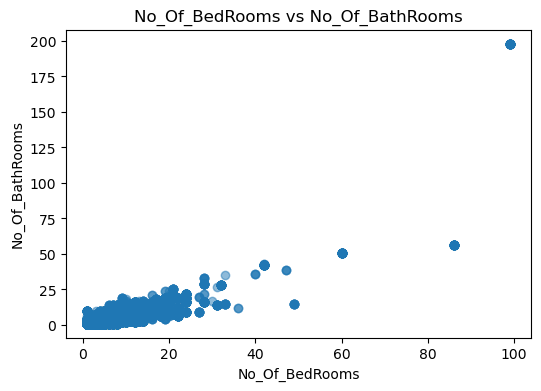

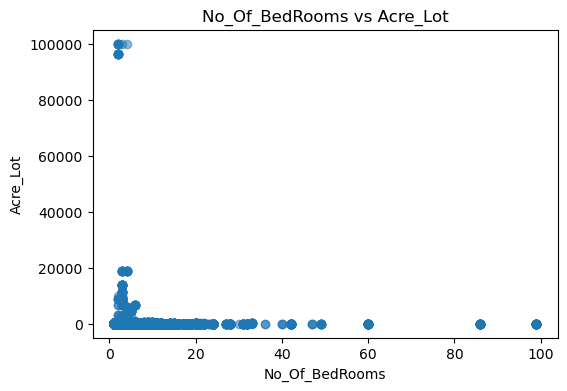

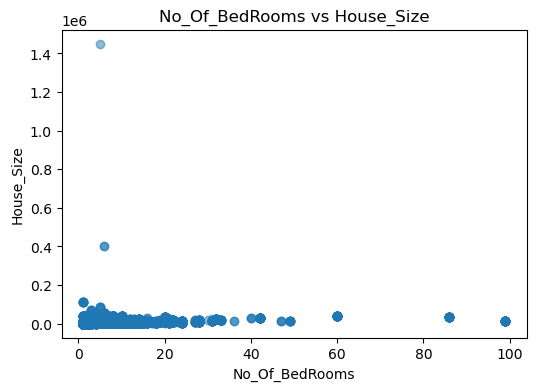

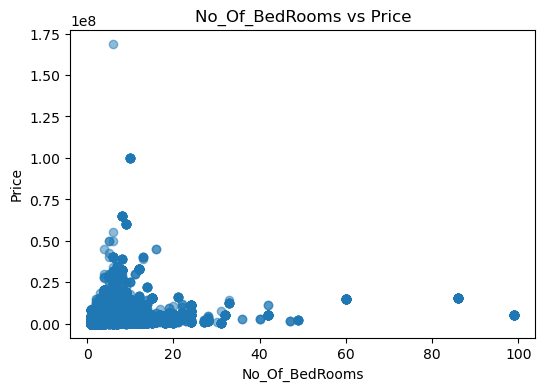

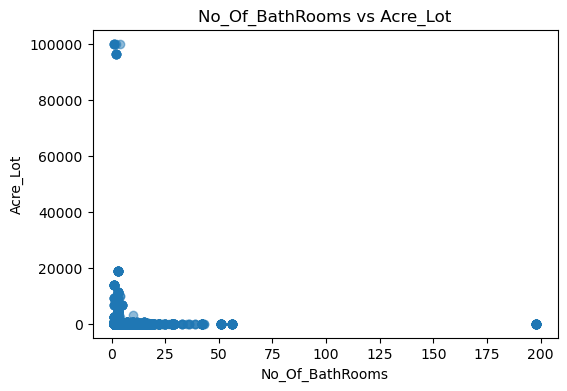

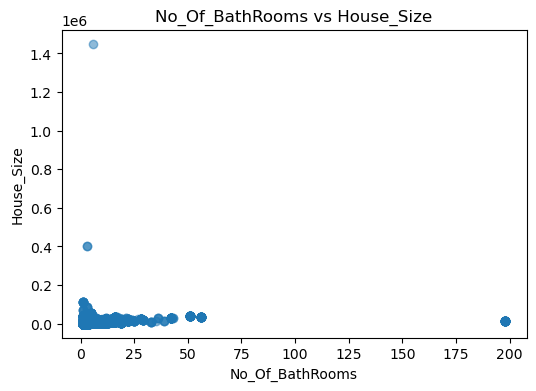

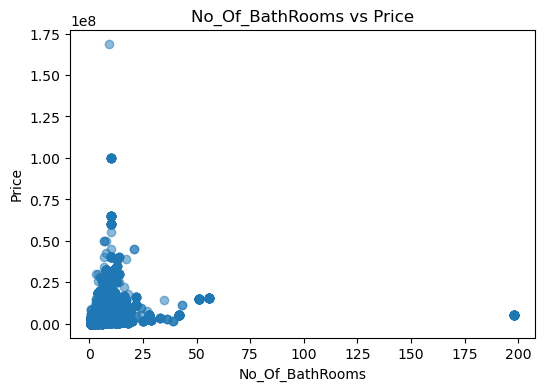

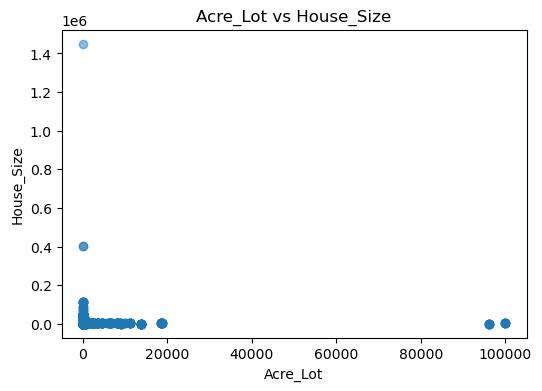

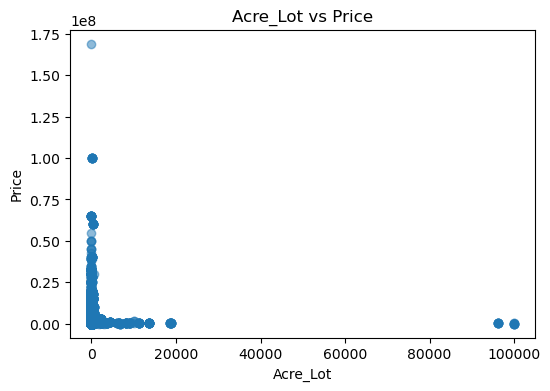

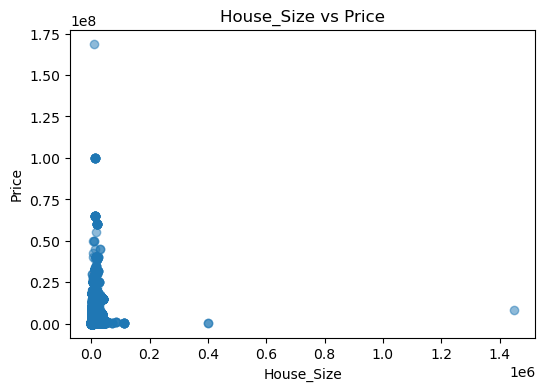

In [22]:
import matplotlib.pyplot as plt

for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        plt.figure(figsize=(6, 4))
        plt.scatter(df_result[numerical_cols[i]], df_result[numerical_cols[j]], alpha=0.5)
        plt.title(f'{numerical_cols[i]} vs {numerical_cols[j]}')
        plt.xlabel(numerical_cols[i])
        plt.ylabel(numerical_cols[j])
        plt.show()


In [23]:
grouped_data = df_result.groupby('City_Name')[numerical_cols].describe()
print(grouped_data)

                 No_Of_BedRooms                                            \
                          count      mean       std  min   25%  50%   75%   
City_Name                                                                   
Abbot                       7.0  3.857143  0.377964  3.0  4.00  4.0  4.00   
Aberdeen                   82.0  3.268293  0.786440  2.0  3.00  3.0  4.00   
Abington                  126.0  3.873016  1.379763  2.0  3.00  3.0  4.00   
Absecon                   175.0  3.731429  1.051483  2.0  3.00  4.0  4.00   
Accord                      5.0  2.800000  0.447214  2.0  3.00  3.0  3.00   
...                         ...       ...       ...  ...   ...  ...   ...   
Yeadon                     12.0  4.000000  0.738549  3.0  3.75  4.0  4.25   
Yonkers                  2408.0  3.705150  1.880371  1.0  3.00  3.0  4.00   
York                      230.0  3.330435  1.396951  1.0  3.00  3.0  4.00   
Yorktown Heights          537.0  3.608939  1.121264  1.0  3.00  4.0  4.00   

## Scatter plot for Number of Bedrooms vs Price

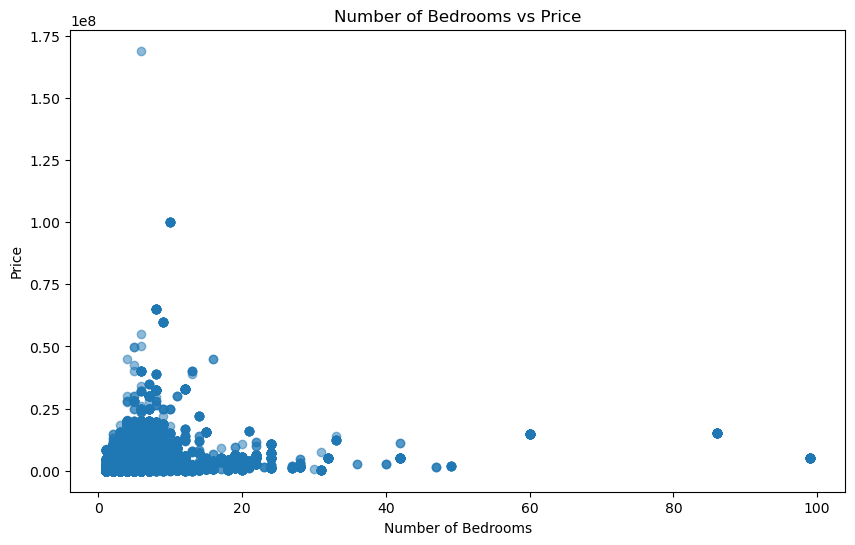

In [24]:
import matplotlib.pyplot as plt

# Scatter plot for Number of Bedrooms vs Price
plt.figure(figsize=(10, 6))
plt.scatter(df_result['No_Of_BedRooms'], df_result['Price'], alpha=0.5)
plt.title('Number of Bedrooms vs Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.show()

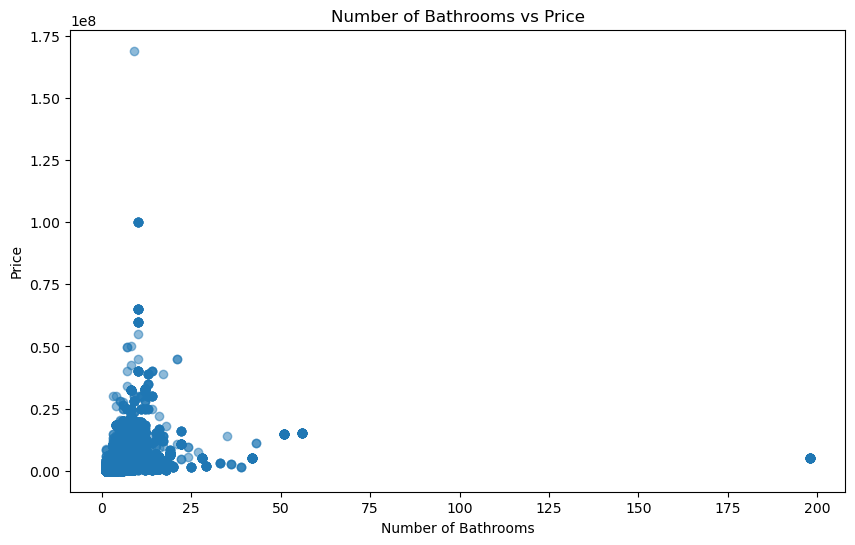

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(df_result['No_Of_BathRooms'], df_result['Price'], alpha=0.5)
plt.title('Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')
plt.show()

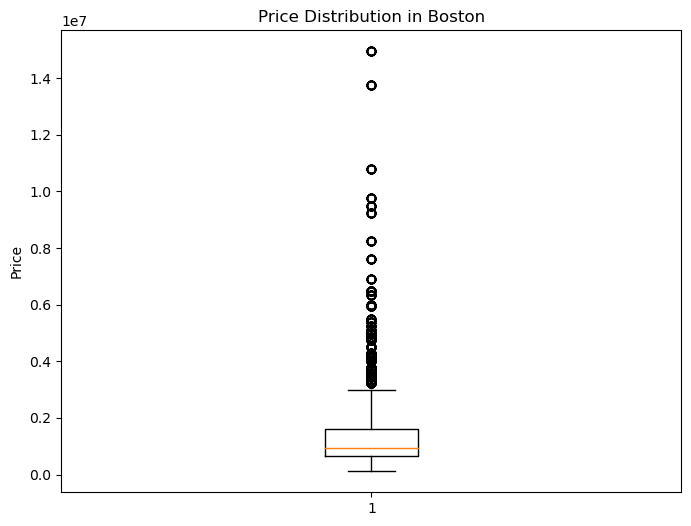

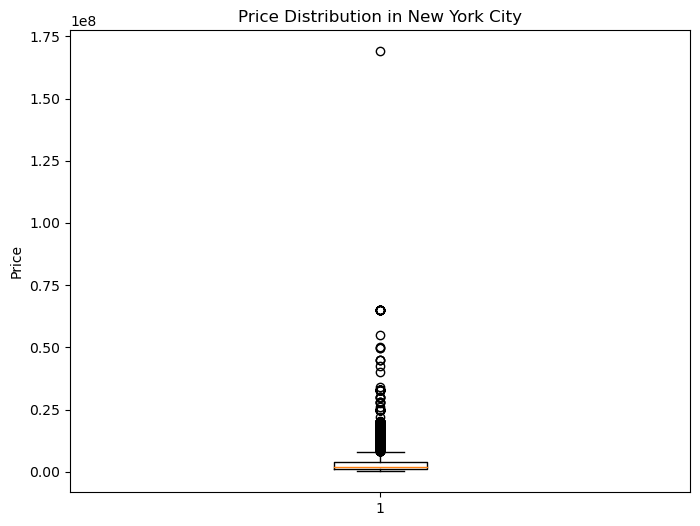

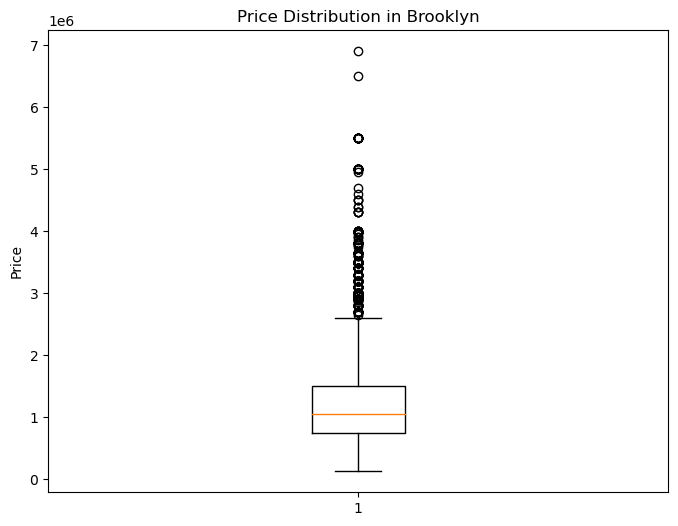

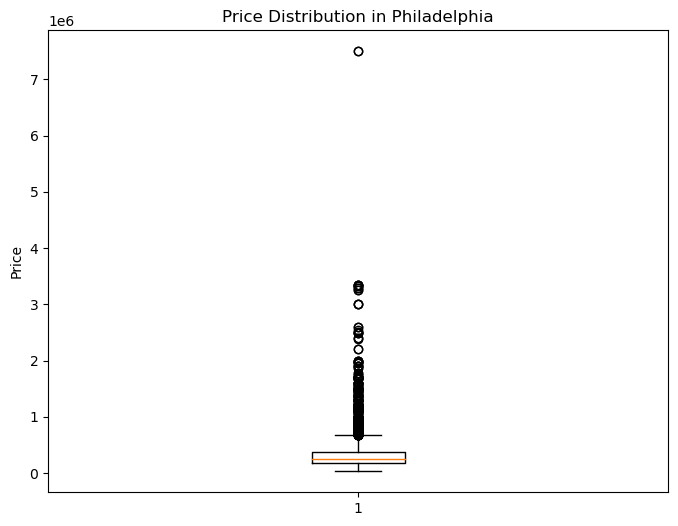

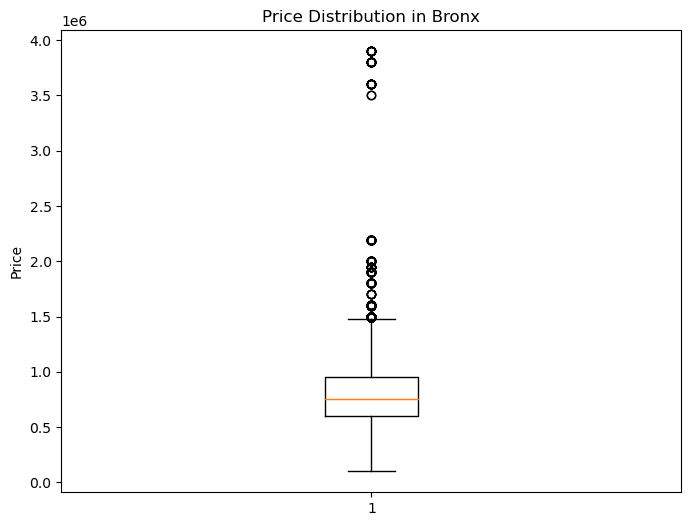

In [26]:
# Since there might be many cities, let's visualize the top 5 cities with the most listings
top_cities = df_result['City_Name'].value_counts().head(5).index

for city in top_cities:
    city_data = df_result[df_result['City_Name'] == city]
    plt.figure(figsize=(8, 6))
    plt.boxplot(city_data['Price'])
    plt.title(f'Price Distribution in {city}')
    plt.ylabel('Price')
    plt.show()


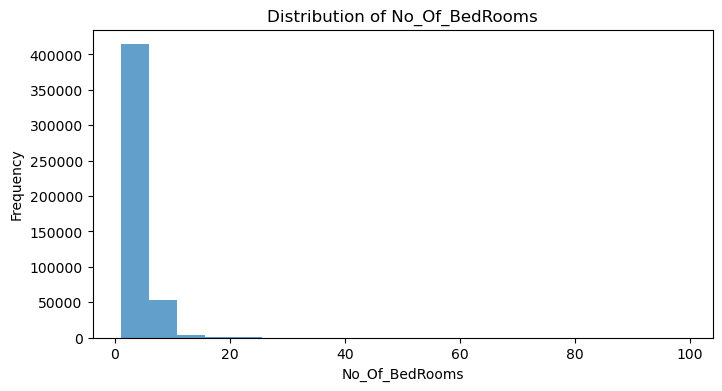

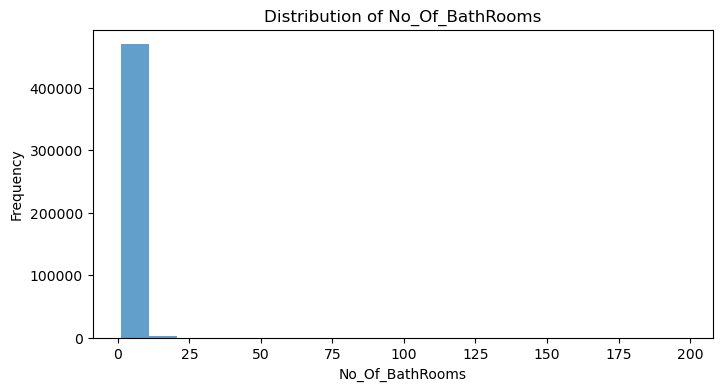

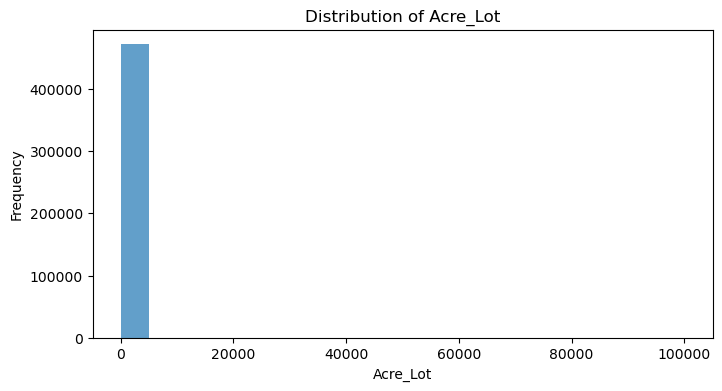

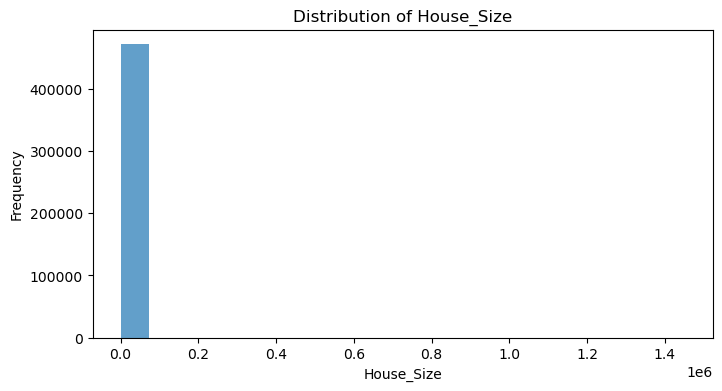

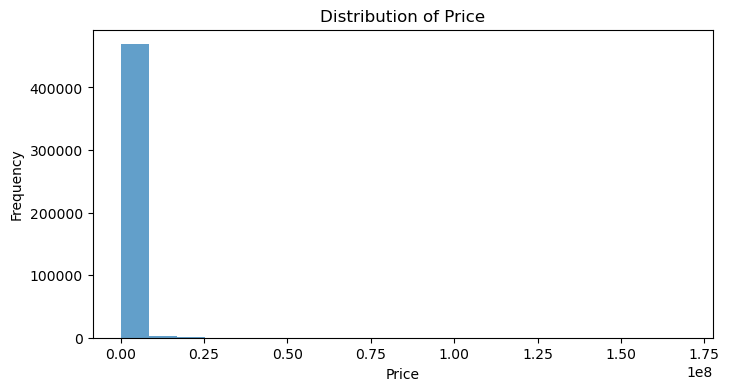

In [27]:
import matplotlib.pyplot as plt

numerical_vars = ['No_Of_BedRooms', 'No_Of_BathRooms', 'Acre_Lot', 'House_Size', 'Price']
for var in numerical_vars:
    plt.figure(figsize=(8, 4))
    plt.hist(df_result[var], bins=20, alpha=0.7)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()


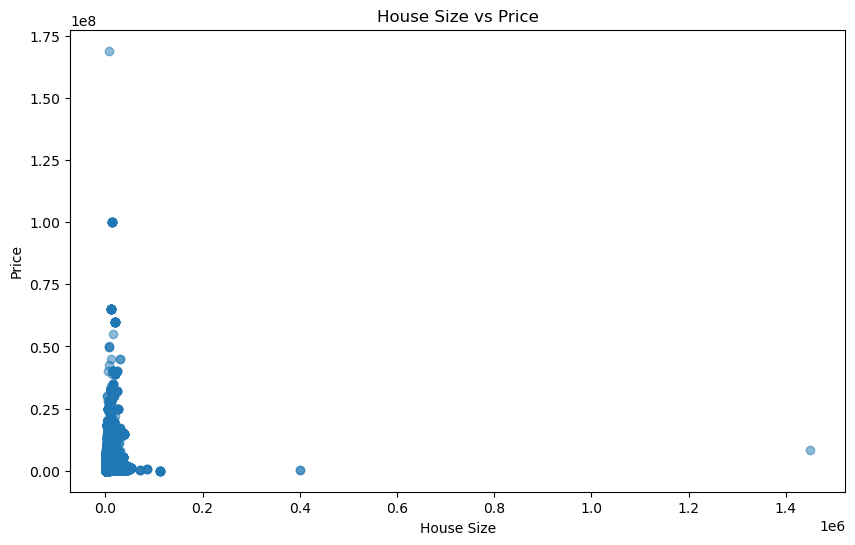

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(df_result['House_Size'],df_result['Price'], alpha=0.5)
plt.title('House Size vs Price')
plt.xlabel('House Size')
plt.ylabel('Price')
plt.show()


# Machine Learning

In [29]:
df_result.describe()

Property_Id  No_Of_BedRooms  No_Of_BathRooms       Acre_Lot  \
count  471562.000000   471562.000000    471562.000000  471562.000000   
mean   235781.500000        3.826307         2.749957       8.721948   
std    136128.368156        2.134664         2.196152     599.623739   
min         1.000000        1.000000         1.000000       0.000000   
25%    117891.250000        3.000000         2.000000       0.110000   
50%    235781.500000        3.000000         2.000000       0.260000   
75%    353671.750000        4.000000         3.000000       0.910000   
max    471562.000000       99.000000       198.000000  100000.000000   

         House_Size        City_Id         Zip_Id         Price  
count  4.715620e+05  471562.000000  471562.000000  4.715620e+05  
mean   2.453424e+03    1190.370783    1454.536286  8.254454e+05  
std    3.278410e+03     705.139242     927.593658  1.587906e+06  
min    1.220000e+02       1.000000       1.000000  5.000000e+02  
25%    1.344000e+03     530.000000     694.000000  2.990000e+05  
50%    1.920000e+03    1252.000000    1298.000000  4.899000e+05  
75%    2.809000e+03    1795.000000    2263.000000  8.200000e+05  
max    1.450112e+06    2347.000000    3047.000000  1.690000e+08

In [30]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471562 entries, 0 to 471561
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Property_Id      471562 non-null  int64  
 1   Status           471562 non-null  object 
 2   No_Of_BedRooms   471562 non-null  int64  
 3   No_Of_BathRooms  471562 non-null  int64  
 4   Acre_Lot         471562 non-null  float64
 5   House_Size       471562 non-null  int64  
 6   City_Id          471562 non-null  int64  
 7   Zip_Id           471562 non-null  int64  
 8   Price            471562 non-null  int64  
 9   City_Name        471562 non-null  object 
 10  Zip_Code         471562 non-null  object 
 11  State_Name       471562 non-null  object 
dtypes: float64(1), int64(7), object(4)
memory usage: 43.2+ MB


In [31]:
df_result.isnull().sum().sort_values(ascending=False)

Property_Id        0
Status             0
No_Of_BedRooms     0
No_Of_BathRooms    0
Acre_Lot           0
House_Size         0
City_Id            0
Zip_Id             0
Price              0
City_Name          0
Zip_Code           0
State_Name         0
dtype: int64

## Model Evaluation

In [32]:
df_result = pd.read_sql_query(sql_query, conn_norm)
categorical_column = ['State_Name']
df_categorical = df_result[categorical_column]

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df_categorical).toarray()
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_column))
df_result_encoded = pd.concat([df_result, df_encoded], axis=1)
print(df_result_encoded.head())

vals = df_result_encoded.iloc[:,[2,3,4,5,6,7,12,13,14,15,16,17,18,19,20,21,22,23,24,25]].values
pred = df_result_encoded.iloc[:,8].values

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test=train_test_split(vals, pred, test_size=0.20)

regressor=LinearRegression()
regressor.fit(X_train,y_train)
y_pred=regressor.predict(X_test)
print(len(y_pred))
print(len(y_test))
MSE = metrics.mean_squared_error(y_test, y_pred, squared=False)
R2 = r2_score(y_test, y_pred)



   Property_Id    Status  No_Of_BedRooms  No_Of_BathRooms  Acre_Lot  \
0            1  for_sale               3                2      0.12   
1            2  for_sale               4                2      0.08   
2            3  for_sale               2                1      0.15   
3            4  for_sale               4                2      0.10   
4            5  for_sale               4                3      0.46   

   House_Size  City_Id  Zip_Id   Price      City_Name  ...  \
0         920       13    2102  105000       Adjuntas  ...   
1        1527       13    2102   80000       Adjuntas  ...   
2         748      982    2706   67000     Juana Diaz  ...   
3        1800     1629    2521  145000          Ponce  ...   
4        2520     1797    2169  179000  San Sebastian  ...   

  State_Name_New Hampshire State_Name_New Jersey  State_Name_New York  \
0                      0.0                   0.0                  0.0   
1                      0.0                   0.0      

Mean Squared Error: 1412315.1857457345
R-squared: 0.24583328026651696


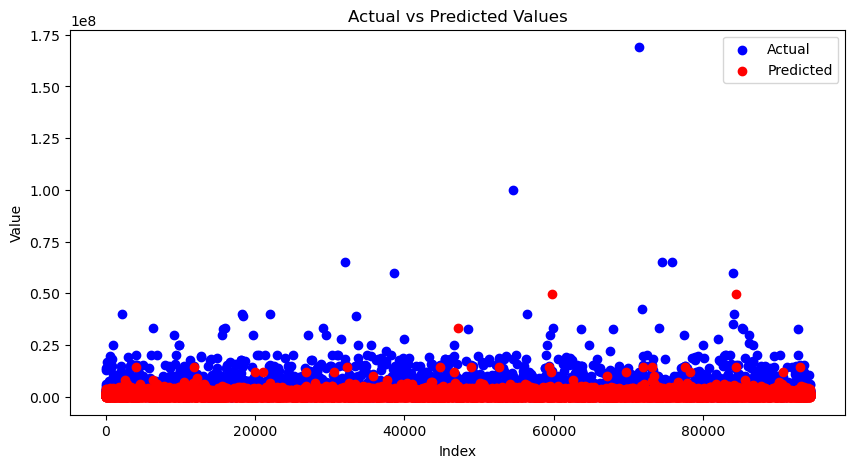

In [33]:
print("Mean Squared Error:", MSE)
print("R-squared:", R2)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Outcome

We got an valuable insights for investors, sellers, and buyers by analyzing data, the project highlights potential areas for high-value investments. 

This information can help sellers price their homes appropriately and inform buyers about expected costs. It's especially useful for investors and those seeking luxury properties, serving as a basis for more detailed analysis. In essence, this project offers a strategic guide for real estate decision-making based on current market trends.